### Candidate number: 1030
***
## Exercise 5

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

In [181]:
class StockData:
    def __init__(self, tickers, start, end, names, period='11Y'):
        self.tickers = tickers
        self.names = {self.tickers[i]: names[i] for i in range(len(tickers))}
        self.df = yf.download(self.tickers, period=period, ignore_tz=True, progress=False)
        self.close = pd.DataFrame(self.df['Adj Close']).loc['2013-01-01':'2023-01-01']
        self.returns = np.log(self.close/self.close.shift()).dropna()
        self.cov = self.returns.cov()

# Ticker symbols:
tickers = ['EQNR.OL', 'DNB.OL', 'MOWI.OL', 'KOG.OL', 'AKRBP.OL']
# Stock names:
stock_names = ['Equinor', 'DNB', 'MOWI', 'Kongsberg Gruppen', 'Aker BP']
# Stock data:
data = StockData(tickers, '2013-01-01', '2023-05-31', names=stock_names)

#### a.)

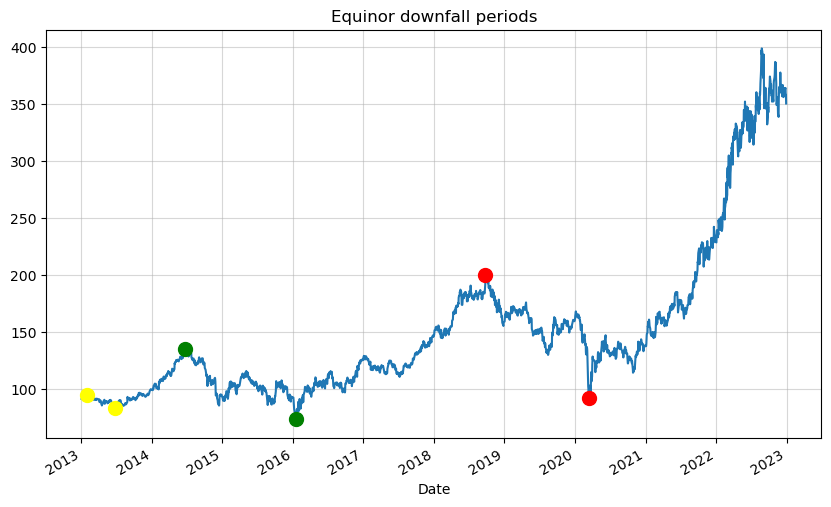

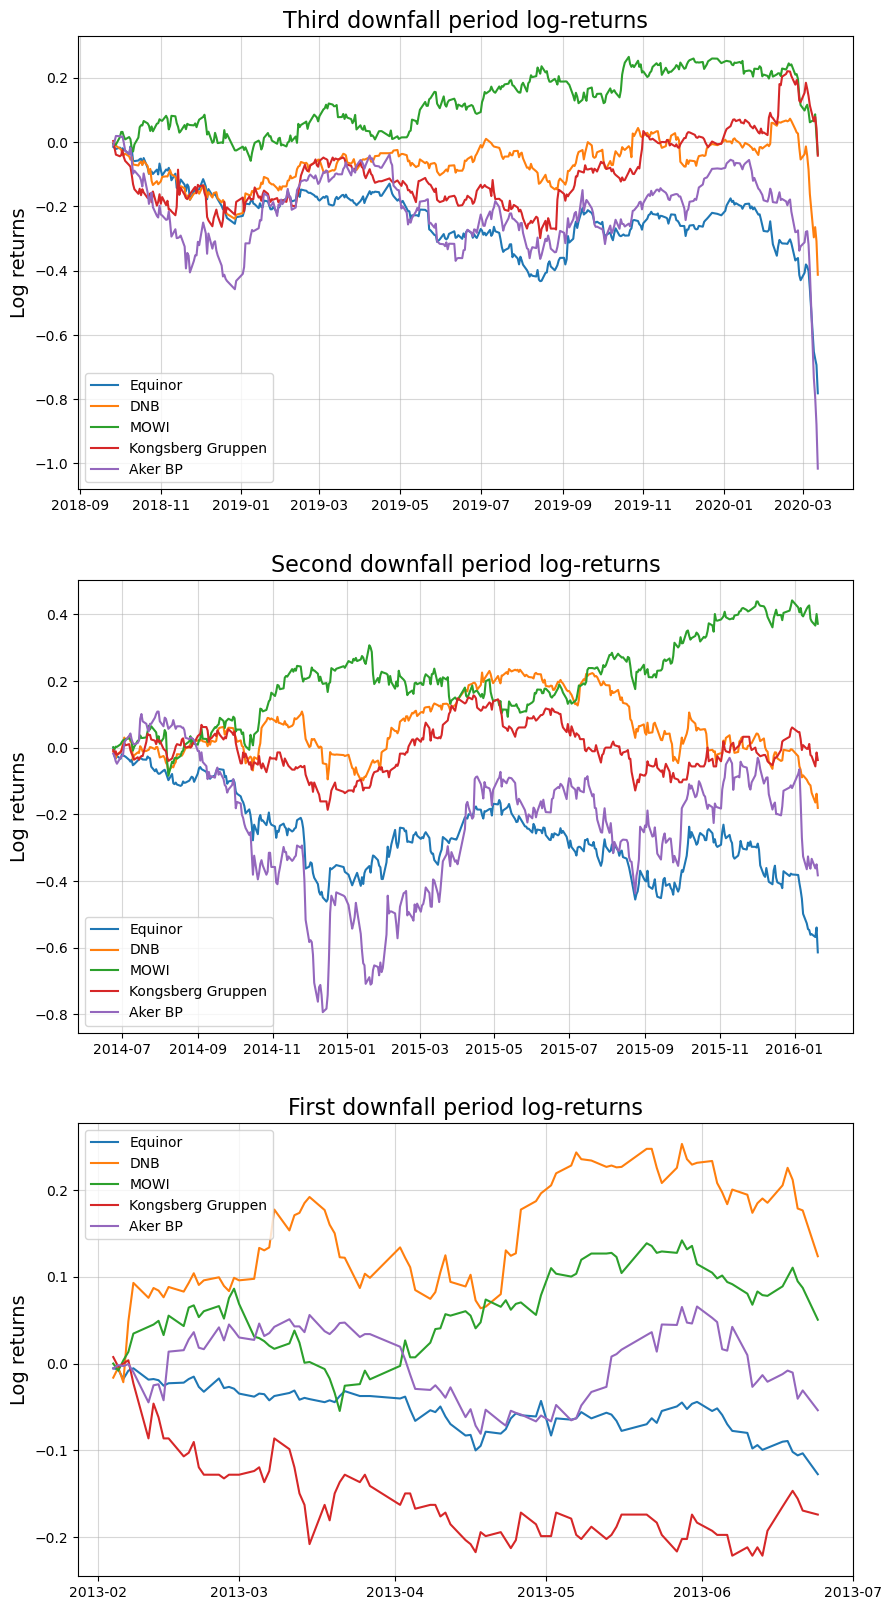

In [182]:
# function for calculating three downfall periods
def calc_downfall(data):
    x1 = np.argmax(np.maximum.accumulate(data) - data)
    y1 = np.argmax(data[:x1])

    x2 = np.argmax(np.maximum.accumulate(data[:y1]) - data[:y1])
    y2 = np.argmax(data[:x2])

    x3 = np.argmax(np.maximum.accumulate(data[:y2]) - data[:y2])
    y3 = np.argmax(data[:x3])

    x = [x1, x2, x3]
    y = [y1, y2, y3]

    return x, y
    
x, y = calc_downfall(data.close['EQNR.OL'])

fig, ax = plt.subplots(figsize=(10, 6))
data.close['EQNR.OL'].plot(ax=ax)
for i, color in enumerate(['red', 'green', 'yellow']):
    plt.plot([data.close['EQNR.OL'].index[y[i]], data.close['EQNR.OL'].index[x[i]]], [data.close['EQNR.OL'][y[i]], data.close['EQNR.OL'][x[i]]], 'o', color=color, markersize=10)
ax.set_title('Equinor downfall periods')
ax.grid(alpha=0.5)

fig, axs = plt.subplots(3, figsize=(10, 20))

for j, period in enumerate(reversed(['First', 'Second', 'Third'])):
    axs[j].plot(data.returns['EQNR.OL'].iloc[y[j]:x[j]].cumsum(), label='Equinor')

    for i, ticker in enumerate(['DNB.OL', 'MOWI.OL', 'KOG.OL', 'AKRBP.OL']):
        axs[j].plot(data.returns[ticker].iloc[y[j]:x[j]].cumsum(), label=data.names[ticker])

    axs[j].legend()
    axs[j].set_title(f'{period} downfall period log-returns', fontsize=16)
    axs[j].grid(alpha=0.5)
    axs[j].set_ylabel('Log returns', fontsize=14)

Mowi seems to have growth in every downfall period Equinor has, this could either be coincidence or be affected by negatively correlated markets, howver a lot more data and analysis would be needed to confirm any relationship between the markets. Aker BP also seem to follow Equinor closely, which could indicate that both companies have downfalls when a common denominator changes, such as an oil price reduction.

b.)

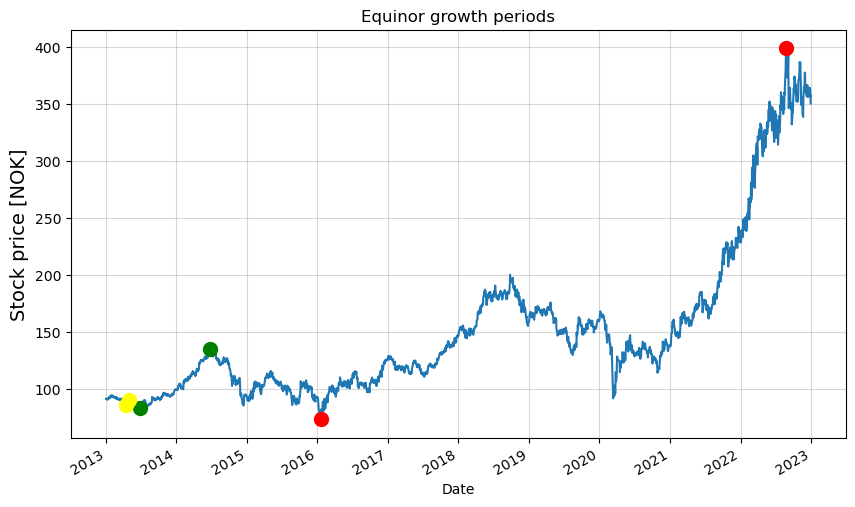

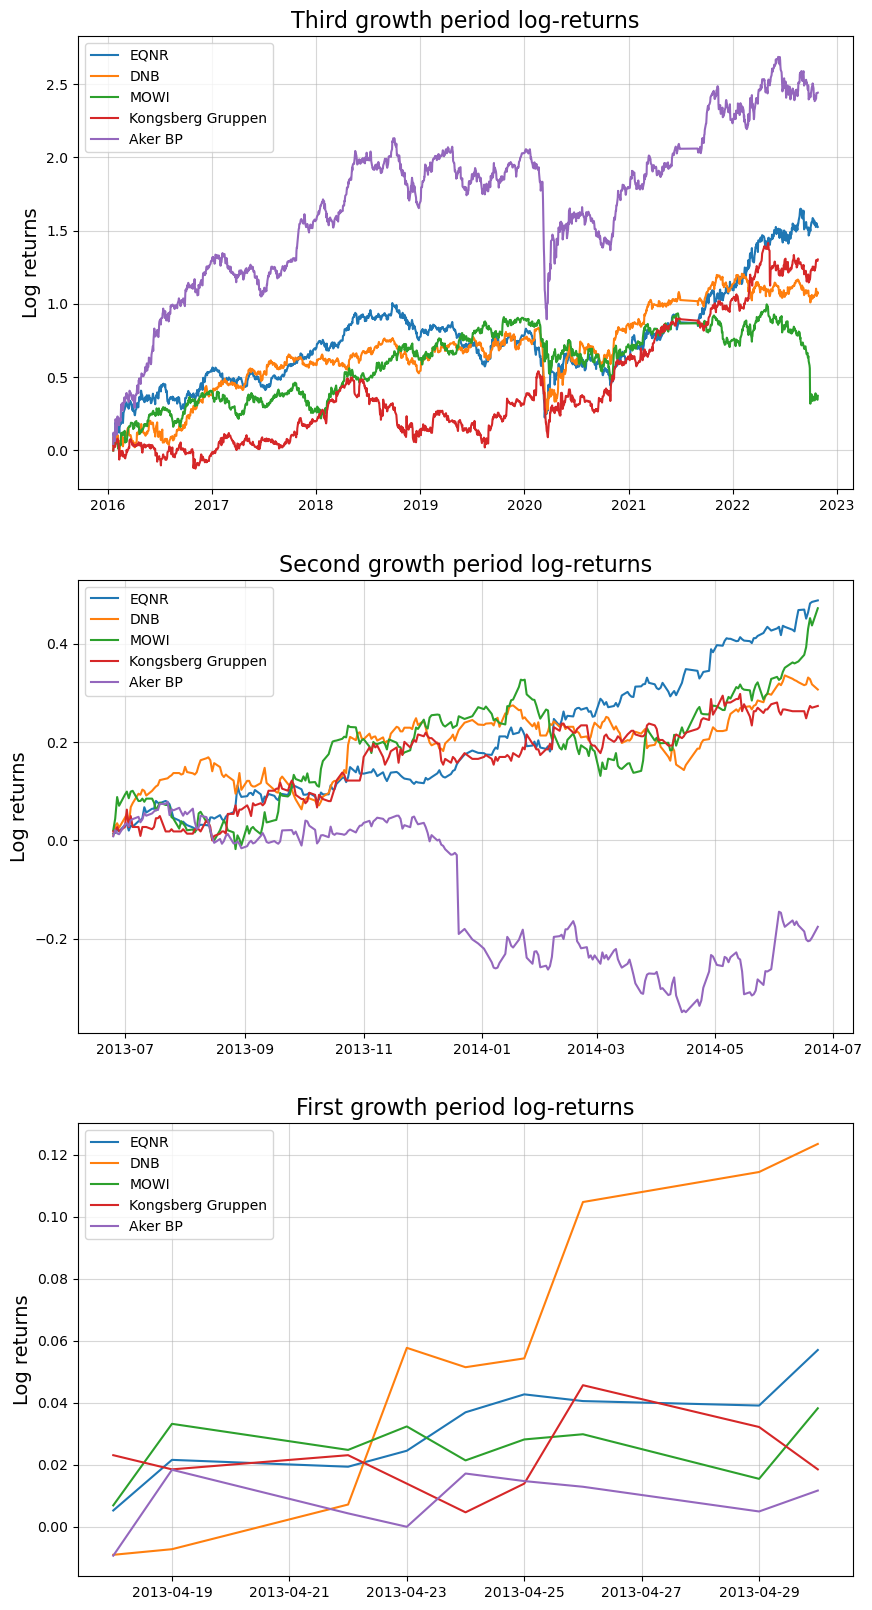

In [183]:
def calc_growth(data):
    x1 = np.argmin(np.minimum.accumulate(data) - data)
    y1 = np.argmin(data[:x1])

    x2 = np.argmin(np.minimum.accumulate(data[:y1]) - data[:y1])
    y2 = np.argmin(data[:x2])

    x3 = np.argmin(np.minimum.accumulate(data[:y2]) - data[:y2])
    y3 = np.argmin(data[:x3])

    x = [x1, x2, x3]
    y = [y1, y2, y3]

    return x, y

x, y = calc_growth(data.close['EQNR.OL'])

fig, ax = plt.subplots(figsize=(10, 6))
data.close['EQNR.OL'].plot(ax=ax)
for i, color in enumerate(['red', 'green', 'yellow']):
    plt.plot([data.close['EQNR.OL'].index[y[i]], data.close['EQNR.OL'].index[x[i]]], [data.close['EQNR.OL'][y[i]], data.close['EQNR.OL'][x[i]]], 'o', color=color, markersize=10)
ax.set_title('Equinor growth periods')
ax.set_ylabel('Stock price [NOK]', fontsize=14)
ax.grid(alpha=0.5)

fig, axs = plt.subplots(3, figsize=(10, 20))

for j, period in enumerate(reversed(['First', 'Second', 'Third'])):
    axs[j].plot(data.returns['EQNR.OL'].iloc[y[j]:x[j]].cumsum(), label='EQNR')

    for i, ticker in enumerate(['DNB.OL', 'MOWI.OL', 'KOG.OL', 'AKRBP.OL']):
        axs[j].plot(data.returns[ticker].iloc[y[j]:x[j]].cumsum(), label=data.names[ticker])

    axs[j].legend()
    axs[j].set_ylabel('Log returns', fontsize=14)
    axs[j].set_title(f'{period} growth period log-returns', fontsize=16)
    axs[j].grid(alpha=0.5)

What differs between Equinor's downfall and growth periods is that most companies follows Equinor closer in its growth periods. Aker BP does not seem to be correlated with Equinors growth rate in some of these periods, where it outperforms it in the last period, but has a heavy fall during the second.

#### c.)

From the downfall plot, it seems that the average donfall of the two largest periods is about 0.6 cumulative log-return. The average growth varies a lot more, between the periods, but could be estimated to be 0.5. 

The Strategy function below sums up cumulative returns until the cumulative sum is either above 0.5 or below -0.5. The strategy will send out a sell signal if the stock has been rising over 0.5 and a buy signal if the stock has fallen below -0.5. The cumulative sum restarts everytime a signal is changed.

In [184]:
# Cumulative log-return strategy
def cumul_strategy(data):
    buy = []
    position = 1
    cumulative = 0
    for i, r in enumerate(data):
        cumulative += r # Add daily log-return

        if cumulative > 0.5:
            position = 0 # Sell signal
            cumulative = 0 # Reset cumulative sum

        elif cumulative < -0.5:
            position = 1 # Buy signal
            cumulative = 0 # Reset cumulative sum

        buy.append(position)

    return buy

#### d.)

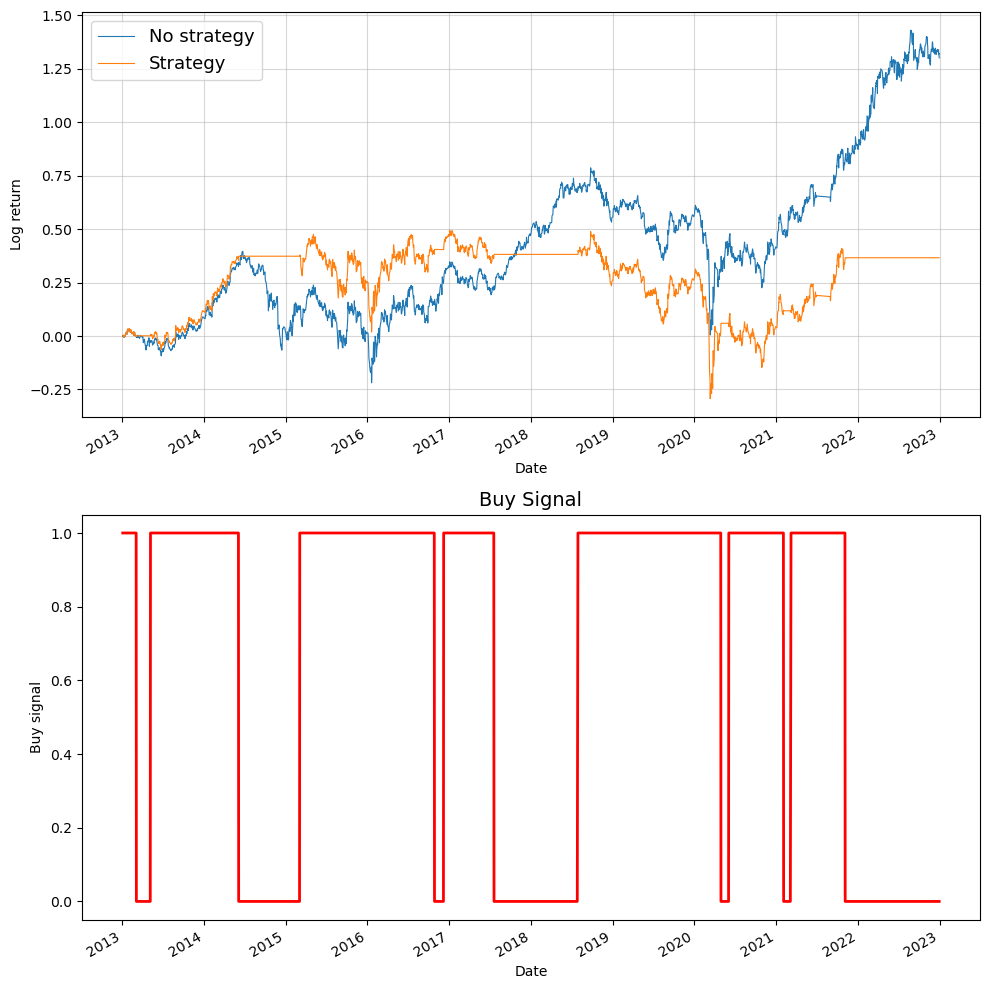

In [185]:
ticker = 'EQNR.OL'

buy_signal = cumul_strategy(data.returns[ticker])
portfolio = pd.DataFrame(buy, columns=['buy'], index=data.returns.index)
portfolio['trade'] = (data.returns[ticker] * portfolio['buy'].shift(1)).cumsum()

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

data.returns[ticker].cumsum().plot(ax=ax1, linewidth=0.8, label='No strategy')
portfolio['trade'].plot(linewidth=0.8, ax=ax1, label='Strategy', ylabel='Log return')
portfolio['buy'].plot(linewidth=2, ax=ax2, color='red', ylabel='Buy signal')
ax1.legend(fontsize=13)
ax1.grid(alpha=0.5)
ax2.set_title('Buy Signal', fontsize=14)
fig.tight_layout()

#### Discussion

The strategy outperforms the No strategy in the first half of the backtest, but falls short of picking up large growth periods. This makes the final return lower than the No Trade strategy.